In [1]:
import pandas as pd
import pipeline as p
import cleaning as c

%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import StandardScaler, OneHotEncoder

pd.set_option('mode.chained_assignment', None)

In [66]:
import datetime as dt

In [2]:
df = p.open_pkl('Data/breast_2000-2015_df.pkl')

In [3]:
df.shape

(592051, 133)

In [30]:
df4 = c.clean_only_mod(df)

In [60]:
# drop TYPE_FU == 1, as we don't know the survival time for these patients
df4 = df4[df4['TYPE_FU'] == '2']

### Censoring Time
1. Convert DX Month to numeric
2. Create DX Date from DX month & year
3. Calcluate Censoring Time = End of Study (12/31/15) - DX Date

In [73]:
def month_plus_year(row):
    return dt.datetime(year = row['YEAR_DX'], month = row['MDXRECMP'], day=1)

In [65]:
df4['MDXRECMP'] = pd.to_numeric(df4['MDXRECMP'])
df4['DATE_DX'] = df4.apply(lambda row: month_plus_year(row), axis=1)

In [84]:
df4['CENSOR_TIME_MON'] = (dt.datetime(year=2015, month=12, day=31) - df4['DATE_DX']) / dt.timedelta(days=30)

In [85]:
df4[['MDXRECMP', 'YEAR_DX', 'DATE_DX','SRV_TIME_MON', 'CENSOR_TIME_MON']].sample(10)

,MDXRECMP,YEAR_DX,DATE_DX,SRV_TIME_MON,CENSOR_TIME_MON
96528,3,2002,2002-03-01,165.0,168.433333
67476,2,2002,2002-02-01,166.0,169.366667
560844,12,2009,2009-12-01,72.0,74.033333
127257,8,2006,2006-08-01,112.0,114.633333
579375,1,2014,2014-01-01,20.0,24.300000
7322,4,2009,2009-04-01,40.0,82.166667
532556,12,2013,2013-12-01,24.0,25.333333
263138,12,2015,2015-12-01,0.0,1.000000
458892,11,2000,2000-11-01,181.0,184.600000
457790,4,2006,2006-04-01,116.0,118.700000


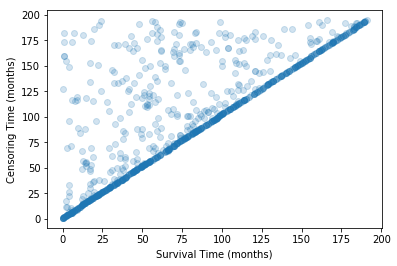

In [92]:
df_test = df4.sample(1000)

plt.scatter(df_test['SRV_TIME_MON'], df_test['CENSOR_TIME_MON'], marker = 'o', alpha = 0.2)
plt.xlabel('Survival Time (months)')
plt.ylabel('Censoring Time (months)');

Most patients' censoring time ~= to survival time -- thus, they are right-censored

In [94]:
import matplotlib

In [95]:
matplotlib.__version__

'3.0.0'

## Old code

In [4]:
df2, df3 = c.clean_and_dropna(df)

In [5]:
df2.head()

,MAR_STAT_MOD,RACE_MOD,AGE_DX,GRADE,TUMSIZ,SURG,SEQ_NUM,PRIMSITE,POS_NODES,HST_STGA,INVAS,TARGET
0,1.0,01,45.0,3.0,40.0,1.0,0,C504,1.0,2.0,1,1
1,0.0,02,49.0,2.0,50.0,1.0,0,C502,1.0,2.0,1,1
4,1.0,01,69.0,2.0,15.0,1.0,0,C504,0.0,1.0,1,1
5,1.0,02,65.0,3.0,34.0,1.0,1,C505,0.0,1.0,1,1
6,1.0,01,34.0,3.0,15.0,1.0,0,C506,0.0,1.0,1,1


In [6]:
df2.shape

(222127, 12)

In [39]:
df3.head()

,MAR_STAT_MOD,RACE_MOD,AGE_DX,GRADE,TUMSIZ,SURG,SEQ_NUM,PRIMSITE,POS_NODES,INVAS,HST_STGA,BRST_SUB,TARGET
589,0.0,3,72.0,3.0,17.0,1.0,0,C504,0.0,1,1.0,3,1
688,1.0,3,72.0,2.0,15.0,1.0,2,C504,0.0,1,1.0,3,1
1108,0.0,3,56.0,3.0,24.0,1.0,3,C508,9.0,1,2.0,3,0
1267,0.0,3,85.0,3.0,8.0,1.0,2,C508,0.0,1,1.0,3,1
1702,0.0,3,83.0,1.0,11.0,1.0,2,C508,0.0,1,1.0,3,1


In [7]:
df3.shape

(19667, 13)

In [6]:
p.pkl_this('Data/breast_df_for_model.pkl', df2)
p.pkl_this('Data/breast_df_with_sub_for_model.pkl', df3)

## Train-Test split

Drop 'PRIMSITE' (primary site) -- later discovered to not be informative

In [7]:
X = df2.drop(columns=['TARGET', 'PRIMSITE'])
y = df2['TARGET']

In [8]:
y.value_counts(1)

1    0.837057
0    0.162943
Name: TARGET, dtype: float64

In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.3, random_state=12, stratify=y)

X_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)

In [10]:
p.pkl_this('Data/X_train_unprocessed.pkl', X_train)
p.pkl_this('Data/y_train_unprocessed.pkl', y_train)
p.pkl_this('Data/X_test_unprocessed.pkl', X_test)
p.pkl_this('Data/y_test_unprocessed.pkl', y_test)

Data with sub-type feature:

In [11]:
Xsub = df3.drop(columns=['TARGET', 'PRIMSITE'])
ysub = df3['TARGET']

In [12]:
ysub.value_counts(1)

1    0.784461
0    0.215539
Name: TARGET, dtype: float64

In [13]:
X_train_sub, X_test_sub, y_train_sub, y_test_sub = train_test_split(
    Xsub, ysub, test_size = 0.3, random_state=12, stratify=ysub)

X_train_sub.reset_index(drop=True, inplace=True)
y_train_sub.reset_index(drop=True, inplace=True)

In [14]:
p.pkl_this('Data/X_train_unproc_with_sub.pkl', X_train_sub)
p.pkl_this('Data/y_train_unproc_with_sub.pkl', y_train_sub)
p.pkl_this('Data/X_test_unproc_with_sub.pkl', X_test_sub)
p.pkl_this('Data/y_test_unproc_with_sub.pkl', y_test_sub)

## Pre-processing Pipeline

In [24]:
X_train.head()

,MAR_STAT_MOD,RACE_MOD,AGE_DX,GRADE,TUMSIZ,SURG,SEQ_NUM,POS_NODES,HST_STGA,INVAS
0,1.0,3,79.0,3.0,15.0,1.0,2,0.0,1.0,1
1,0.0,3,94.0,2.0,20.0,1.0,0,0.0,1.0,1
2,0.0,3,80.0,3.0,1.0,1.0,0,0.0,1.0,1
3,1.0,3,76.0,1.0,18.0,1.0,0,0.0,1.0,1
4,1.0,3,84.0,1.0,8.0,1.0,2,0.0,1.0,1


In [15]:
# for dataframe without sub-type
preprocessor1 = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), [2,4,7]), # age, tumor size, pos_nodes
        ('cat', OneHotEncoder(categories='auto', handle_unknown='ignore'), [1]) # race_mod
    ], remainder='passthrough')

In [16]:
# for dataframe with sub-type
preprocessor2 = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), [2,4,7]), # age, tumor size, pos_nodes
        ('cat', OneHotEncoder(categories='auto', handle_unknown='ignore', ), [1,10]) # race, BRST_SUB
    ], remainder='passthrough')

In [17]:
X_tr_proc = preprocessor1.fit_transform(X_train)

In [18]:
X_tr_proc[0]

array([ 1.41189499, -0.30159618, -0.39079147,  1.        ,  0.        ,
        0.        ,  1.        ,  3.        ,  1.        ,  2.        ,
        1.        ,  1.        ])

In [19]:
len(X_tr_proc[0])

12

In [20]:
preprocessor1.named_transformers_['cat'].get_feature_names()

array(['x0_01', 'x0_02', 'x0_03'], dtype=object)

In [21]:
p.pkl_this('Data/preprocess_wo_sub.pkl', preprocessor1)
p.pkl_this('Data/preprocess_with_sub.pkl', preprocessor2)